# Demo and Inspection:
# hearing samples, visualizing clusters with plots, etc...

## 1 Gather Audio Samples

In [3]:
#IPython.display.Audio can play sample audio 

from datasets import load_dataset
import IPython.display as ipd
from itertools import islice


# Load streaming version — no full download!
dataset = load_dataset(
    "google/speech_commands",
    "v0.02",
    split="train",
    streaming=True,
    trust_remote_code=True
)

# Load feature names to decode label
label_names = dataset.features['label'].names

# Preview a few samples
for sample in islice(dataset, 10):
    audio = sample['audio']
    label_id = sample['label']
    label_name = label_names[label_id]
    print(f"Label ID: {label_id} — Word: {label_name}")
    display(ipd.Audio(audio['array'], rate=audio['sampling_rate']))

Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


In [1]:
# outputs how many samples generated in .csv from load.dataset.py
import pandas as pd

df = pd.read_csv("backward_features.csv")
print("Number of samples:", len(df))
print("Unique speakers:", df['speaker_id'].nunique())

Number of samples: 20
Unique speakers: 20


## Cluster Demo

In [6]:
# Load CSV
import pandas as pd
df = pd.read_csv("backward_features.csv")

In [4]:
# reformatting CSV
# Expand MFCCs back into numeric columns
import ast

# Convert stringified MFCCs to lists
df['mfcc_mean'] = df['mfcc_mean'].apply(ast.literal_eval)

# Expand into separate columns
mfcc_df = pd.DataFrame(df['mfcc_mean'].tolist(), columns=[f'mfcc_{i}' for i in range(13)])

# Combine with rest of the features
df_cleaned = pd.concat([mfcc_df, df.drop(columns=['mfcc_mean', 'speaker_id'])], axis=1)


In [5]:
# Standardize features (very important for PCA + KMeans)
from sklearn.preprocessing import StandardScaler

# Drop metadata not used for clustering
X = df.drop(columns=["speaker_id"])  # drop 'label' if you kept it

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned)

In [6]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [7]:
from sklearn.cluster import KMeans

# Run KMeans clustering (tryuing k =2 to 5)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels back to DataFrame
df_cleaned["cluster"] = clusters

# View average feature values per cluster
cluster_summary = df_cleaned.groupby("cluster").mean()
display(cluster_summary)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,pitch_mean,tempo,energy_mean
cluster,,,,,,,,,,,,,,,,
0,-429.696375,118.492329,-3.914608,3.399966,-5.443501,-1.309987,-8.042936,-15.487911,-5.423836,-5.591945,-6.614389,-1.703440,-5.855476,150.511796,175.167872,0.044670
1,-370.386199,100.607802,-1.562998,21.141951,9.447466,7.404764,-6.125651,1.758218,-3.631699,1.262582,-1.098852,2.852602,-0.188011,137.281844,163.676168,0.036450
2,72.521038,75.196611,-4.109487,21.877609,8.487282,6.295436,-1.966189,5.548834,6.097893,7.297109,-1.747833,2.682929,2.478009,125.627649,156.250000,0.624123


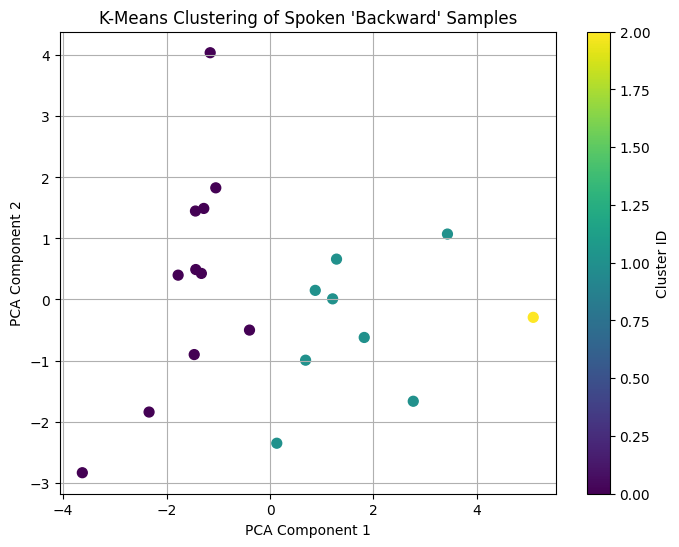

In [8]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50)
plt.title("K-Means Clustering of Spoken 'Backward' Samples")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.show()

# This PCA plot maps each audio sample into 2D based on delivery-related features (like pitch, tempo, etc.).
# Color shows the cluster assignment; axes are combinations of original features capturing most variation.

note: KMeans is grouping together audio clips that sound similar in terms of how they're spoken, not what word is spoken or who is speaking. For example: